#Predicting Spotify Song Streams Data Processing   
Team 9  


This notebook focuses on feature engineering and initial data preprocessing.

We:
- Loaded the original Spotify Top Songs and Audio Features dataset.
- Created new features related to artist popularity and industry recognition, including number of collaborators, artist followers, artist popularity score, total Grammy wins, total Grammy nominations, and TikTok virality.
- Preprocessed categorical variables for future modeling.
- Saved the processed dataset for subsequent model evaluation and training.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/spotify_top_songs_audio_features.csv')

**Create a column with number of collaborators**

In [ ]:
df['num_collaborators'] = df['artist_names'].apply(lambda x: len(x.split(',')))

                 artist_names  num_collaborators
0         ZAYN, PARTYNEXTDOOR                  2
1                Alessia Cara                  1
2                 The Killers                  1
3  Cardi B, Chance the Rapper                  2
4     Post Malone, The Weeknd                  2


**Create a column with artists fllowers**     
Extracted the variables from Spotify's API.

In [ ]:
pip install spotipy tqdm

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="71bc46efd52b442099a11f6d3047e47c",
                                                           client_secret="785bfc2cbd6741aaa0cfc6fb0b022c49"))

In [ ]:
import time
from tqdm import tqdm


def get_artist_followers(artist_name):
    try:
        results = sp.search(q='artist:' + artist_name, type='artist', limit=1)
        if results['artists']['items']:
            return results['artists']['items'][0]['followers']['total']
    except Exception as e:
        print(f"Error retrieving followers for {artist_name}: {e}")
    return 0


unique_artists = set()
for names in df['artist_names']:
    for a in names.split(','):
        unique_artists.add(a.strip())


artist_followers_dict = {}
for artist in tqdm(unique_artists, desc="Fetching artist followers"):
    artist_followers_dict[artist] = get_artist_followers(artist)
    time.sleep(0.5)  # Avoid hitting rate limits


def get_max_follower_from_collab(artist_names_str):
    artists = [a.strip() for a in artist_names_str.split(',')]
    follower_counts = [artist_followers_dict.get(a, 0) for a in artists]
    return max(follower_counts) if follower_counts else 0


df['artist_followers'] = df['artist_names'].apply(get_max_follower_from_collab)

**Create a column to get artists populairty using spotify api**

In [ ]:

def get_artist_popularity(artist_name):
    try:
        results = sp.search(q='artist:' + artist_name, type='artist', limit=1)
        if results['artists']['items']:
            return results['artists']['items'][0]['popularity']
    except Exception as e:
        print(f"Error getting popularity for {artist_name}: {e}")
    return 0


unique_artists = set()
for names in df['artist_names']:
    for name in names.split(','):
        unique_artists.add(name.strip())


artist_popularity_dict = {}
for artist in tqdm(unique_artists, desc="Fetching artist popularity"):
    artist_popularity_dict[artist] = get_artist_popularity(artist)
    time.sleep(0.5)


def get_max_popularity(artist_names_str):
    artists = [a.strip() for a in artist_names_str.split(',')]
    popularity_scores = [artist_popularity_dict.get(a, 0) for a in artists]
    return max(popularity_scores) if popularity_scores else 0


df['artist_popularity'] = df['artist_names'].apply(get_max_popularity)

**Create a column to add total grammy awards & total nominations**

Utilized Chat GPT to add two columns—Total Grammy Awards and Total Grammy Nominations—by scraping IMDb. Parsed the artist_names field, split on commas, and generated a unique list of ~340 performers. For each artist asked Chat GPT to query IMDb’s “name” search, captured the top profile match, appended “/awards,” and, with BeautifulSoup, scanned every award table row containing “Grammy Award.” Rows labeled “Won” incremented the wins counter; rows labeled “Nominee” incremented nominations.

**Create a column about Tiktok Viral or not**

Extracted TikTok viral songs datasets from Kaggle and identified the  overlapping songs with the Spotify dataset using Excel functions.

**Final Dataset**

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/final_spotify.csv')
df.head()

,id,artist_names,track_name,source,key,mode,time_signature,danceability,energy,speechiness,...,tempo,duration_ms,weeks_on_chart,streams,num_collaborators,artist_followers,artist_popularity,Total Grammy Awards,Total Nominations,TikTok_Viral
0,000xQL6tZNLJzIrtIgxqSl,"ZAYN, PARTYNEXTDOOR",Still Got Time (feat. PARTYNEXTDOOR),RCA Records Label,G,Major,4 beats,0.748,0.627,0.0639,...,120.963,188491,17,107527761,2,23713940,83.0,0,0,Not Viral
1,003eoIwxETJujVWmNFMoZy,Alessia Cara,Growing Pains,Def Jam Recordings,C#/Db,Minor,4 beats,0.353,0.755,0.7330,...,191.153,193680,2,9944865,1,12085390,75.0,1,4,Not Viral
2,003vvx7Niy0yvhvHt4a68B,The Killers,Mr. Brightside,Island Records,C#/Db,Major,4 beats,0.352,0.911,0.0747,...,148.033,222973,125,512388123,1,7760689,79.0,0,0,Not Viral
3,00B7TZ0Xawar6NZ00JFomN,"Cardi B, Chance the Rapper",Best Life (feat. Chance The Rapper),Atlantic/KSR,A,Major,4 beats,0.620,0.625,0.5530,...,167.911,284856,2,11985346,2,25197819,77.5,1,7,Not Viral
4,00Blm7zeNqgYLPtW6zg8cj,"Post Malone, The Weeknd",One Right Now (with The Weeknd),Republic Records,C#/Db,Major,4 beats,0.687,0.781,0.0530,...,97.014,193507,30,301860377,2,102588498,93.0,4,33,Not Viral


In [ ]:
cleaned_df = df.drop(columns=['id', 'artist_names', 'track_name', 'source','streams'])

cleaned_df['TikTok_Viral'] = cleaned_df['TikTok_Viral'].replace({'Viral': 1, 'Not Viral': 0})

categorical_columns = ['key', 'mode', 'time_signature']
cleaned_df = pd.get_dummies(cleaned_df, columns=categorical_columns, drop_first=True)

<ipython-input-18-1b69ded41a7f>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_df['TikTok_Viral'] = cleaned_df['TikTok_Viral'].replace({'Viral': 1, 'Not Viral': 0})


Include the correlation matrix to check that our features, including dummy variables, are not highly correlated and to avoid potential multicollinearity issues in modeling.

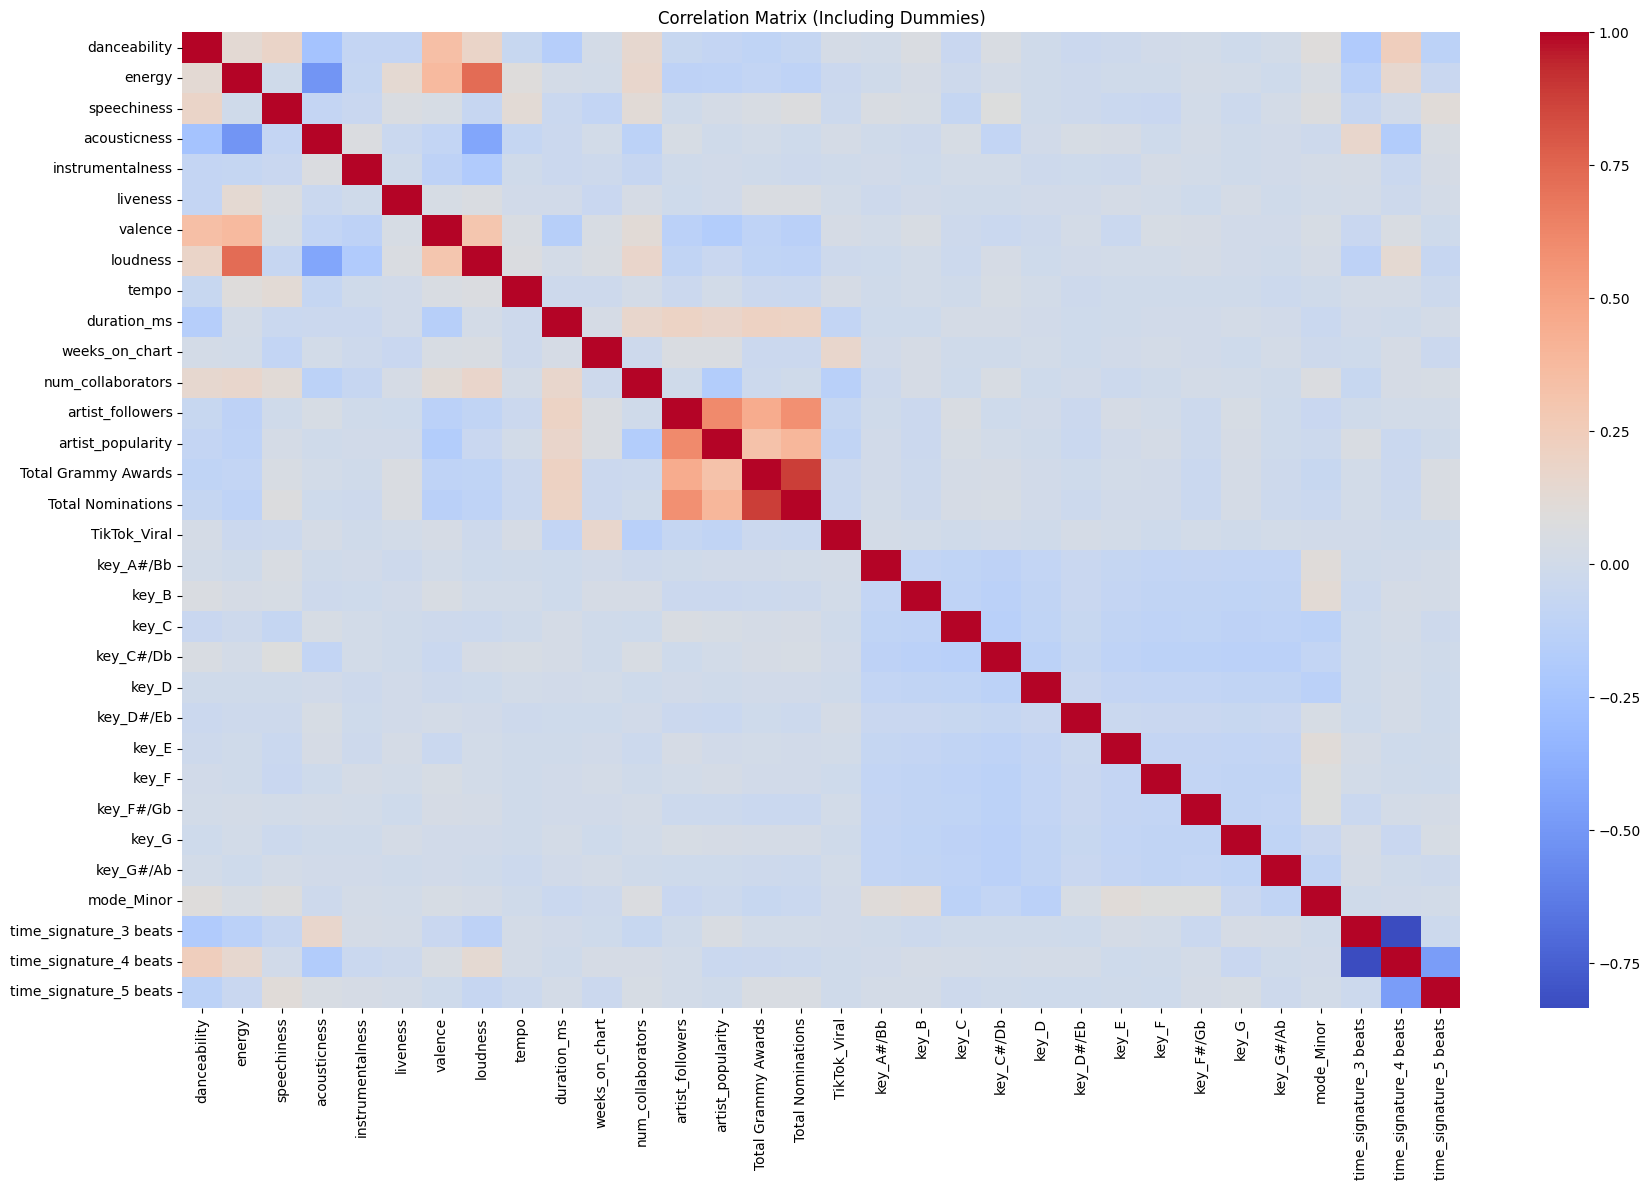

In [ ]:
# Correlation matrix after preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
corr = cleaned_df.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix (Including Dummies)')
plt.tight_layout()
plt.show()

The correlation matrix confirms that our one-hot encoded variables are not highly correlated, reducing the risk of multicollinearity in modeling.